In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime
from pytz import timezone
from pandas.plotting import register_matplotlib_converters
import scipy
from scipy.optimize import Bounds
from scipy.optimize import LinearConstraint
from scipy.optimize import minimize

register_matplotlib_converters()
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
def plot_col(data , col_name):
    plt.figure(figsize=(16, 6))
    plt.plot(data.index, data[col_name], label=col_name, color='purple', )
    # plt.plot(data.index, data['col_name'], label='col_name', color='purple', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel(f'{col_name}')
    plt.legend()
    plt.show()

In [3]:
def download_data(symbols, start_date, end_date):

    try:
        data = yf.download(symbols, start=start_date, end=end_date, interval='1d')['Adj Close']
    except: 
        SyntaxError("Exception in downloading data")
    data.replace([np.inf, -np.inf], np.nan, inplace=True)
    data.dropna(inplace=True)
    # data = data.reset_index()
    # timestamp_column_name = data.columns[0]  # Assuming the timestamp is the first column
    # data = data[[timestamp_column_name, 'Close']]
    # data.columns = ['timestamp', 'price']
    # print(symbol, start_date, end_date, interval, data.shape[0])
    return data

In [4]:
train_start = datetime(2022, 11, 1, tzinfo=timezone('Asia/Tehran'))
train_end = datetime(2023, 11, 1, tzinfo=timezone('Asia/Tehran'))
cryptos = ['BTC-USD', 'ETH-USD', 'USDT-USD', 'SOL-USD',]

In [5]:
df = download_data(cryptos, train_start, train_end)

[*********************100%%**********************]  4 of 4 completed


In [6]:
df.head()

,BTC-USD,ETH-USD,SOL-USD,USDT-USD
Date,,,,
2022-10-31,20495.773438,1572.714478,32.611038,0.999947
2022-11-01,20485.273438,1579.704590,32.248425,0.999924
2022-11-02,20159.503906,1519.711792,30.788076,0.999996
2022-11-03,20209.988281,1531.541748,30.843880,1.000007
2022-11-04,21147.230469,1645.093384,33.780853,1.000076


In [7]:
randomWeights = [0.2, 0.5, 0.2, 0.1]

money_at_first = 1000

ret_data = df.pct_change()[1:]

# print(ret_data)


In [8]:
randomweighted_returns = (randomWeights * ret_data)
# print(randomweighted_returns)

In [9]:
port_ret_with_random_weights = randomweighted_returns.sum(axis=1)

print(port_ret_with_random_weights)

Date
2022-11-01   -0.000106
2022-11-02   -0.031219
2022-11-03    0.004757
2022-11-04    0.065397
2022-11-05    0.013753
                ...   
2023-10-27   -0.014410
2023-10-28   -0.000447
2023-10-29    0.015362
2023-10-30    0.016897
2023-10-31    0.023042
Length: 365, dtype: float64


In [10]:
def sortinoRate(rets , TargetReturn):
    downside_returns = np.minimum(0 , rets-TargetReturn)
    downside_variance =  np.mean(downside_returns**2)
    downside_std = np.sqrt(downside_variance)
    sortino_rate = (np.mean(rets) - TargetReturn) / downside_std

    return sortino_rate

#### Random Weight statistics


In [11]:
expected_port_return = np.mean(port_ret_with_random_weights) 
annual_risk_free_ratio = 0.04
daily_risk_free_ratio =  (1+annual_risk_free_ratio) ** (1/365) -1
initialCapital = 1000


In [12]:
def calculateRequirements(weights:list):
    weighted_rets = ret_data * weights
    port_ret = weighted_rets.sum(axis=1)
    expected_optimized_port_return = np.mean(port_ret)
    stdDevOfRets = np.std(port_ret)
    op_port_cumulative_returns  = np.cumprod(1+port_ret)

    return [expected_optimized_port_return , stdDevOfRets , port_ret , op_port_cumulative_returns]

def calcSharpe(expRet , stdDevRet):
    sharpe = np.sqrt(365) * ((expRet - daily_risk_free_ratio) / stdDevRet) 
    return sharpe

def calcSortino(portRets):
     sortino = np.sqrt(365) * sortinoRate(portRets , 0)
     return sortino
def calcNetProfit(op_port_cumulative_returns):
    netPOverTime  = initialCapital * op_port_cumulative_returns
    final_net_p = netPOverTime[-1] - initialCapital
    return final_net_p
def get_reverse_sharpeRatio(weights:list):
    op_expectedPortfolioReturn  , op_stdDevRet , port_rets , op_port_cumulative_returns = calculateRequirements(weights=weights)
    op_sharpe = calcSharpe(op_expectedPortfolioReturn , op_stdDevRet)
    reverseSharpe = 1/(1+op_sharpe) 
    return reverseSharpe
def get_reverse_sortinoRatio(weights:list):
    op_expectedPortfolioReturn  , op_stdDevRet, port_rets , op_port_cumulative_returns = calculateRequirements(weights=weights)
    op_sortino = calcSortino(port_rets)
    reverseSortino = 2/(1+op_sortino) 
    return reverseSortino

def get_reverse_net_profit(weights:list):
    op_expectedPortfolioReturn  , op_stdDevRet, port_rets , op_port_cumulative_returns = calculateRequirements(weights=weights)
    netProfit = calcNetProfit(op_port_cumulative_returns=op_port_cumulative_returns)
    reverseNetProfit = 1/netProfit
    return reverseNetProfit
    

def check_sum_constraint(weights:list):
    # checks if sum of weights is 1 or not
    return np.sum(weights) - 1

def mix_weights(sharpe_weights, sortino_weights, net_profit_weights) -> list:
    lenght = len(sharpe_weights)
    mixed_weights = [0 for _ in range(lenght)]
    for i in range(lenght):
        mixed_weights[i] = (sharpe_weights[i]+ sortino_weights[i] + net_profit_weights[i]) / 3
    sum = np.sum(mixed_weights)

    if sum < 1:
        rem = sum -1
        max_val = max(mixed_weights)
        index_max_val = mixed_weights.index(max_val)
        mixed_weights[index_max_val] += rem
    elif sum > 1:
        rem = 1 - sum
        max_val = max(mixed_weights)
        index_max_val = mixed_weights.index(max_val)
        mixed_weights[index_max_val] -= rem
        
    return mixed_weights

In [13]:

std_of_returns = np.std(port_ret_with_random_weights)
randomWeightedSharpRatio_1year = np.sqrt(365) * ((expected_port_return - daily_risk_free_ratio) / std_of_returns)
randomWeightedSortinoRatio_1year = np.sqrt(365) * sortinoRate(port_ret_with_random_weights , 0)
port_cumulative_returns  = np.cumprod(1+port_ret_with_random_weights)
net_profit_over_time_1year = initialCapital * port_cumulative_returns

final_net_profit = net_profit_over_time_1year[-1] - initialCapital
final_net_profit_percent = final_net_profit/initialCapital * 100
print("Random Weight Sharpe Ratio:{:.2f}".format(randomWeightedSharpRatio_1year))
print("Random Weight Sortino Ratio:{:.2f}".format(randomWeightedSortinoRatio_1year))
print("Random Weight Net Profit: {:.4f}$".format(final_net_profit) + " percentage:" + "{:.2f}%".format(final_net_profit_percent))

Random Weight Sharpe Ratio:0.72
Random Weight Sortino Ratio:1.14
Random Weight Net Profit: 320.9268$ percentage:32.09%


In [14]:
op_expectedPortfolioReturn  , op_stdDevRet, port_rets , op_port_cumulative_returns = calculateRequirements(weights=randomWeights)
# std_of_returns = np.std(port_ret_with_random_weights)
randomWeightedSharpRatio_1year = calcSharpe(op_expectedPortfolioReturn, op_stdDevRet)
randomWeightedSortinoRatio_1year =calcSortino(port_rets)
# port_cumulative_returns  = np.cumprod(1+port_ret_with_random_weights)
# net_profit_over_time_1year = initialCapital * port_cumulative_returns
net_profit_over_time_1year = calcNetProfit(op_port_cumulative_returns)

# final_net_profit = net_profit_over_time_1year[-1] - initialCapital
# final_net_profit_percent = final_net_profit/initialCapital * 100
print("Random Weight Sharpe Ratio:{:.2f}".format(randomWeightedSharpRatio_1year))
print("Random Weight Sortino Ratio:{:.2f}".format(randomWeightedSortinoRatio_1year))
# print("Random Weight Net Profit: {:.4f}$".format(final_net_profit) + " percentage:" + "{:.2f}%".format(final_net_profit_percent))

Random Weight Sharpe Ratio:0.72
Random Weight Sortino Ratio:1.14


# Optimization Problem:
so here we have a optimization problem in which we want to maximize sharpe ratio | sortino rate | net profit. 
for sharpe ratio and sortino rate we can say that in other words we want to minimize 1/1+sharpe ratio and 1/1+sortino ratio
so now we define appropriate functions to give to scipy for this purpose  


### Important Note:

We should write the calculations from the point that weights come to the play because we are optimizing weights.

## setting constraints and bounds on weights

In [15]:
bounds = tuple((0,1) for coin in range(len(cryptos)))


constraints = ({'type': 'eq', 'fun': check_sum_constraint}) 
initialWeightGuess = len(cryptos) * [1/len(cryptos)]


<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

### Optimizing Sharpe on 1 year period

In [16]:
optimizedSharpe_1year = minimize(get_reverse_sharpeRatio , initialWeightGuess , method='SLSQP' , bounds=bounds , constraints=constraints)

op_weights_for_sharpe_1year = optimizedSharpe_1year.x
print("OUR RANDOM WEIGHTS: ")
print(randomWeights)
print('-' *100)


print("OPTIMIZED WEIGHTS  SHARPE: ")
print(op_weights_for_sharpe_1year)
print('-' *100)


op_expectedPortfolioReturn  , op_stdDevRet, port_rets , op_port_cumulative_returns = calculateRequirements(weights=op_weights_for_sharpe_1year)
optimizedSharpeRatio_1year = calcSharpe(op_expectedPortfolioReturn , op_stdDevRet)


print("SHARPE WITH RANDOM WEIGHTS:")
print(randomWeightedSharpRatio_1year)
print('-' *100)
print("SHARPE WITH OPTIMIZED WEIGHTS:")
print(optimizedSharpeRatio_1year)

OUR RANDOM WEIGHTS: 
[0.2, 0.5, 0.2, 0.1]
----------------------------------------------------------------------------------------------------
OPTIMIZED WEIGHTS  SHARPE: 
[1.00000000e+00 0.00000000e+00 0.00000000e+00 1.40165657e-15]
----------------------------------------------------------------------------------------------------
SHARPE WITH RANDOM WEIGHTS:
0.7154680730266295
----------------------------------------------------------------------------------------------------
SHARPE WITH OPTIMIZED WEIGHTS:
1.2703947162753841


#### Optimizing Sortino for the 1 year period

In [17]:
optimizedSortino_1year = minimize(get_reverse_sortinoRatio , initialWeightGuess , method='SLSQP' , bounds=bounds , constraints=constraints)

op_weights_for_sortino_1year = optimizedSortino_1year.x

print("OUR RANDOM WEIGHTS: ")
print(randomWeights)
print('-' *100)


print("OPTIMIZED WEIGHTS FOR SORTINO: ")
print(op_weights_for_sortino_1year)
print('-' *100)

op_expectedPortfolioReturn  , op_stdDevRet, port_rets , op_port_cumulative_returns = calculateRequirements(weights=op_weights_for_sortino_1year)
optimizedSortinoRatio_1year = calcSortino(portRets=port_rets)

print("SORTINO WITH RANDOM WEIGHTS:")
print(randomWeightedSortinoRatio_1year)
print('-' *100)
print("SORTINO WITH OPTIMIZED WEIGHTS:")
print(optimizedSortinoRatio_1year)

OUR RANDOM WEIGHTS: 
[0.2, 0.5, 0.2, 0.1]
----------------------------------------------------------------------------------------------------
OPTIMIZED WEIGHTS FOR SORTINO: 
[7.55675381e-01 4.64905892e-16 6.10622664e-16 2.44324619e-01]
----------------------------------------------------------------------------------------------------
SORTINO WITH RANDOM WEIGHTS:
1.1427977239166411
----------------------------------------------------------------------------------------------------
SORTINO WITH OPTIMIZED WEIGHTS:
2.1265314144318967


### Optimizing Net Profit for the 1 year period


In [18]:
optimizedNetProfit = minimize(
    get_reverse_net_profit,
    initialWeightGuess,
    method="SLSQP",
    bounds=bounds,
    constraints=constraints,
)


op_weights_for_net_profit_1year = optimizedNetProfit.x
print("OUR RANDOM WEIGHTS: ")
print(randomWeights)
print("-" * 100)


print("OPTIMIZED WEIGHTS FOR NET PROFIT: ")
print(op_weights_for_net_profit_1year)
print("-" * 100)


(
    op_expectedPortfolioReturn,
    op_stdDevRet,
    port_rets,
    op_port_cumulative_returns,
) = calculateRequirements(weights=op_weights_for_net_profit_1year)
optimizedNetProfitVal_1year = calcNetProfit(
    op_port_cumulative_returns=op_port_cumulative_returns
)
optimizedNetProfitPercent_1year = optimizedNetProfitVal_1year / initialCapital * 100
final_net_profit_year1 = final_net_profit
print("NET Profit WITH RANDOM WEIGHTS:")
print("{:.2f}".format(final_net_profit) + '$' + " percentage: " + "{:.2f}%".format(final_net_profit_percent))
print("-" * 100)
print("NET PROFIT WITH OPTIMIZED WEIGHTS:")
print(
    "{:.2f}".format(optimizedNetProfitVal_1year) + '$'+
     ' percentage: '
    + "{:.2f}%".format(optimizedNetProfitPercent_1year)
)

OUR RANDOM WEIGHTS: 
[0.2, 0.5, 0.2, 0.1]
----------------------------------------------------------------------------------------------------
OPTIMIZED WEIGHTS FOR NET PROFIT: 
[6.48920814e-01 0.00000000e+00 3.51079186e-01 1.99493200e-17]
----------------------------------------------------------------------------------------------------
NET Profit WITH RANDOM WEIGHTS:
320.93$ percentage: 32.09%
----------------------------------------------------------------------------------------------------
NET PROFIT WITH OPTIMIZED WEIGHTS:
610.59$ percentage: 61.06%


### Optimizing metrics for the 1 year period based on mixing optimized weights.


In [19]:
# mixed_weights_last_year = mix_weights(op_weights_for_sharpe_1year, op_weights_for_sortino_1year, op_weights_for_net_profit_1year)

# mixed_return  , op_stdDevRet, port_rets , op_port_cumulative_returns = calculateRequirements(weights=mixed_weights_last_year)
# mixed_sharpe = calcSharpe(mixed_return , op_stdDevRet)
# mixed_sortino = calcSortino(portRets=port_rets)
# mixed_net_profit_val= calcNetProfit(
#     op_port_cumulative_returns=op_port_cumulative_returns
# )
# net_profit_percent = mixed_net_profit_val / initialCapital * 100


# print("OPTIMIZED WEIGHTS FOR MIX OF 3 METRICS: ")
# print(mixed_weights_last_year)
# print('-' * 100)
# print('SHARPE RATIO:\n', randomWeightedSharpRatio_1year, ' ---->', mixed_sharpe)
# print('-' * 100)
# print('SORTINO RATIO:\n', randomWeightedSortinoRatio_1year, ' ----> ', mixed_sortino)
# print('-' * 100)
# print('NET PROFIT:')
# print(final_net_profit, ' ----> ',
#     "{:.2f}".format(mixed_net_profit_val) + '$'+
#      ' percentage: '
#     + "{:.2f}%".format(net_profit_percent)
# )
# print("-" * 100)


In [20]:
# import matplotlib.pyplot as plt

# # Assuming the initial values of your metrics
# random_metrics = [randomWeightedSharpRatio_1year, randomWeightedSortinoRatio_1year,]
# mixed_metrics = [mixed_sharpe, mixed_sortino, ]

# labels = ['Sharpe Ratio', 'Sortino Ratio']

# x = range(len(labels))
# # 
# plt.bar(x, random_metrics, width=0.2, label='random', color='b', align='center')
# plt.bar(x, mixed_metrics, width=0.2, label='mixed', color='r', align='edge')

# plt.xlabel('Metrics')
# plt.ylabel('Values')
# plt.title('Comparison')
# plt.xticks(x, labels)
# plt.legend()
# plt.show()


<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

# Testing our weights with 1month Test period
### testing performance of our portfolio weights with random weights, optimized weights and new optimized weights based on new time period.


In [21]:
test_start = datetime(2023, 11, 2, tzinfo=timezone('Asia/Tehran'))
test_end = datetime(2023, 12, 2, tzinfo=timezone('Asia/Tehran'))
new_df =  download_data(cryptos, test_start, test_end)

[*********************100%%**********************]  4 of 4 completed


In [22]:
randomWeights = [0.2, 0.5, 0.2, 0.1]

money_at_first = 1000

ret_data = new_df.pct_change()[1:]

# print(ret_data)

randomweighted_returns = (randomWeights * ret_data)
# print(randomweighted_returns)
port_ret_with_random_weights = randomweighted_returns.sum(axis=1)


# print(port_ret_with_random_weights)

In [23]:
expected_port_return = np.mean(port_ret_with_random_weights) 
annual_risk_free_ratio = 0.04
daily_risk_free_ratio =  (1+annual_risk_free_ratio) ** (1/365) -1
std_of_returns = np.std(port_ret_with_random_weights)
initialCapital = 1000
randomWeightedSharpRatio = np.sqrt(365) * ((expected_port_return - daily_risk_free_ratio) / std_of_returns)
randomWeightedSortinoRatio = np.sqrt(365) * sortinoRate(port_ret_with_random_weights , 0)
port_cumulative_returns  = np.cumprod(1+port_ret_with_random_weights)
net_profit_over_time = initialCapital * port_cumulative_returns

final_net_profit = net_profit_over_time[-1] - initialCapital
final_net_profit_percent = final_net_profit/initialCapital * 100
print("Random Weight Sharpe Ratio:{:.3f}".format(randomWeightedSharpRatio))
print("Random Weight Sortino Ratio:{:.2f}".format(randomWeightedSortinoRatio))
print("Random Weight Net Profit: {:.4f}$".format(final_net_profit) + " percentage:" + "{:.2f}%".format(final_net_profit_percent))

Random Weight Sharpe Ratio:3.882
Random Weight Sortino Ratio:7.41
Random Weight Net Profit: 177.2353$ percentage:17.72%


### Optimizing sharpe for the 1 month period


In [24]:
op_expectedPortfolioReturnLastYear  , op_stdDevRet, port_rets , op_port_cumulative_returns = calculateRequirements(weights=op_weights_for_sharpe_1year)
optimizedSharpeRatioLastYear = calcSharpe(op_expectedPortfolioReturnLastYear , op_stdDevRet)


optimizedSharpe = minimize(get_reverse_sharpeRatio , initialWeightGuess , method='SLSQP' , bounds=bounds , constraints=constraints)
op_weights_for_sharpe = optimizedSharpe.x
print("OUR RANDOM WEIGHTS: ")
print(randomWeights)
print('-' *100)


print("OPTIMIZED WEIGHTS FOR SHARPE: ")
print(op_weights_for_sharpe)
print('-' *100)


op_expectedPortfolioReturn  , op_stdDevRet, port_rets , op_port_cumulative_returns = calculateRequirements(weights=op_weights_for_sharpe)
optimizedSharpeRatio = calcSharpe(op_expectedPortfolioReturn , op_stdDevRet)


print("SHARPE WITH RANDOM WEIGHTS:")
print(randomWeightedSharpRatio)
print('-' *100)
print("SHARPE WITH OPTIMIZED WEIGHTS ON LAST YEAR:")
print(optimizedSharpeRatioLastYear)
print('-'*100)
print("SHARPE WITH OPTIMIZED WEIGHTS ON LAST MONTH:")
print(optimizedSharpeRatio)

OUR RANDOM WEIGHTS: 
[0.2, 0.5, 0.2, 0.1]
----------------------------------------------------------------------------------------------------
OPTIMIZED WEIGHTS FOR SHARPE: 
[0.00000000e+00 5.16277478e-01 4.83722522e-01 1.00613933e-17]
----------------------------------------------------------------------------------------------------
SHARPE WITH RANDOM WEIGHTS:
3.882068854612128
----------------------------------------------------------------------------------------------------
SHARPE WITH OPTIMIZED WEIGHTS ON LAST YEAR:
2.658912994609548
----------------------------------------------------------------------------------------------------
SHARPE WITH OPTIMIZED WEIGHTS ON LAST MONTH:
4.204088624853109


### Optimizing sortino for the 1 month period


In [25]:
op_expectedPortfolioReturn , op_stdDevRet, port_rets , op_port_cumulative_returns = calculateRequirements(weights=op_weights_for_sortino_1year)
optimizedSortinoRatioLastYear = calcSortino(portRets=port_rets)

optimizedSortino = minimize(get_reverse_sortinoRatio , initialWeightGuess , method='SLSQP' , bounds=bounds , constraints=constraints)

op_weights_for_sortino = optimizedSortino.x

print("OUR RANDOM WEIGHTS: ")
print(randomWeights)
print('-' *100)


print("OPTIMIZED WEIGHTS FOR SORTINO: ")
print(op_weights_for_sortino)
print('-' *100)


op_expectedPortfolioReturn  , op_stdDevRet, port_rets , op_port_cumulative_returns = calculateRequirements(weights=op_weights_for_sortino)
optimizedSortinoRatio = calcSortino(portRets=port_rets)


print("SORTINO WITH RANDOM WEIGHTS:")
print(randomWeightedSortinoRatio)
print('-' *100)
print("SORTINO WITH OPTIMIZED WEIGHTS ON LAST YEAR:")
print(optimizedSortinoRatioLastYear)
print('-' *100)
print("SORTINO WITH OPTIMIZED WEIGHTS ON LAST MONTH:")
print(optimizedSortinoRatio)

OUR RANDOM WEIGHTS: 
[0.2, 0.5, 0.2, 0.1]
----------------------------------------------------------------------------------------------------
OPTIMIZED WEIGHTS FOR SORTINO: 
[0.00000000e+00 4.00161352e-01 5.99838648e-01 3.61786691e-16]
----------------------------------------------------------------------------------------------------
SORTINO WITH RANDOM WEIGHTS:
7.410485717237132
----------------------------------------------------------------------------------------------------
SORTINO WITH OPTIMIZED WEIGHTS ON LAST YEAR:
4.511040520596667
----------------------------------------------------------------------------------------------------
SORTINO WITH OPTIMIZED WEIGHTS ON LAST MONTH:
8.130256899587566


### Optimizing net profit for the 1 month period


In [26]:
(
    op_expectedPortfolioReturn,
    op_stdDevRet,
    port_rets,
    op_port_cumulative_returns,
) = calculateRequirements(weights=op_weights_for_net_profit_1year)
optimizedNetProfitValLastYear = calcNetProfit(
    op_port_cumulative_returns=op_port_cumulative_returns
)
optimizedNetProfitPercentLastYear = optimizedNetProfitValLastYear / initialCapital * 100


optimizedNetProfit = minimize(
    get_reverse_net_profit,
    initialWeightGuess,
    method="SLSQP",
    bounds=bounds,
    constraints=constraints,
)

op_weights_for_net_profit = optimizedNetProfit.x
print("OUR RANDOM WEIGHTS: ")
print(randomWeights)
print("-" * 100)


print("OPTIMIZED WEIGHTS FOR NET PROFIT: ")
print(op_weights_for_net_profit)
print("-" * 100)


(
    op_expectedPortfolioReturn,
    op_stdDevRet,
    port_rets,
    op_port_cumulative_returns,
) = calculateRequirements(weights=op_weights_for_net_profit)
optimizedNetProfitVal = calcNetProfit(
    op_port_cumulative_returns=op_port_cumulative_returns
)
optimizedNetProfitPercent = optimizedNetProfitVal / initialCapital * 100

print("NET Profit WITH RANDOM WEIGHTS:")
print("{:.2f}".format(final_net_profit) + '$' + " percentage: " + "{:.2f}%".format(final_net_profit_percent))
print("-" * 100)

print("NET PROFIT WITH OPTIMIZED WEIGHTS ON LAST YEAR:")
print(
    "{:.2f}".format(optimizedNetProfitValLastYear) + '$'+
     ' percentage: '
    + "{:.2f}%".format(optimizedNetProfitPercentLastYear)
)
print("-" * 100)
print("NET PROFIT WITH OPTIMIZED WEIGHTS ON LAST MONTH:")
print(
    "{:.2f}".format(optimizedNetProfitVal) + '$'+
     ' percentage: '
    + "{:.2f}%".format(optimizedNetProfitPercent)
)

OUR RANDOM WEIGHTS: 
[0.2, 0.5, 0.2, 0.1]
----------------------------------------------------------------------------------------------------
OPTIMIZED WEIGHTS FOR NET PROFIT: 
[5.12819878e-17 0.00000000e+00 1.00000000e+00 1.35491691e-17]
----------------------------------------------------------------------------------------------------
NET Profit WITH RANDOM WEIGHTS:
177.24$ percentage: 17.72%
----------------------------------------------------------------------------------------------------
NET PROFIT WITH OPTIMIZED WEIGHTS ON LAST YEAR:
217.13$ percentage: 21.71%
----------------------------------------------------------------------------------------------------
NET PROFIT WITH OPTIMIZED WEIGHTS ON LAST MONTH:
442.40$ percentage: 44.24%


### Optimizing metrics for the 1 month period based on mixing optimized weights.


In [ ]:
# mixed_weights = mix_weights(op_weights_for_sharpe, op_weights_for_sortino, op_weights_for_net_profit)

# mixed_return  , op_stdDevRet, port_rets , op_port_cumulative_returns = calculateRequirements(weights=mixed_weights)
# mixed_sharpe = calcSharpe(mixed_return , op_stdDevRet)
# mixed_sortino = calcSortino(portRets=port_rets)
# mixed_net_profit_val= calcNetProfit(
#     op_port_cumulative_returns=op_port_cumulative_returns
# )
# net_profit_percent = mixed_net_profit_val / initialCapital * 100


# print("OPTIMIZED WEIGHTS FOR MIX OF 3 METRICS: ")
# print(mixed_weights)
# print('-' * 100)
# print('SHARPE RATIO:\n', randomWeightedSharpRatio, ' ---->', mixed_sharpe)
# print('-' * 100)
# print('SORTINO RATIO:\n', randomWeightedSortinoRatio, ' ----> ', mixed_sortino)
# print('-' * 100)
# print('NET PROFIT:')
# print(final_net_profit, ' ----> ',
#     "{:.2f}".format(mixed_net_profit_val) + '$'+
#      ' percentage: '
#     + "{:.2f}%".format(net_profit_percent)
# )
# print("-" * 100)


In [ ]:
# print('Net Profit:\n')
# print('Random       Last-year       OPTIMIZED')
# print(f'{round(final_net_profit,2)}       {round(optimizedNetProfitValLastYear)}            {round(optimizedNetProfitVal,2)}')


# metrics = [randomWeightedSharpRatio, randomWeightedSharpRatio_1year,optimizedSharpeRatioLastYear, optimizedSharpeRatio]
# # last_year_metrics = [optimizedSharpeRatioLastYear,optimizedSortinoRatioLastYear,]
# # mixed_metrics = [optimizedSharpeRatio, optimizedSortinoRatio, ]

# labels = ['Sharpe Ratio']

# x = range(len(labels))

# plt.bar(x, optimizedSharpeRatioLastYear, width=0.2, label='mixed', color='r', align='center')
# # plt.bar(x, metrics, width=0.2, label='random', color='b', align='center')
# plt.bar(x, randomWeightedSharpRatio_1year, width=0.2, label='last year', color='g', align='edge')

# plt.xlabel('Metrics')
# plt.ylabel('Values')
# plt.title('Comparison')
# plt.xticks(x, labels)
# plt.legend()
# plt.show()


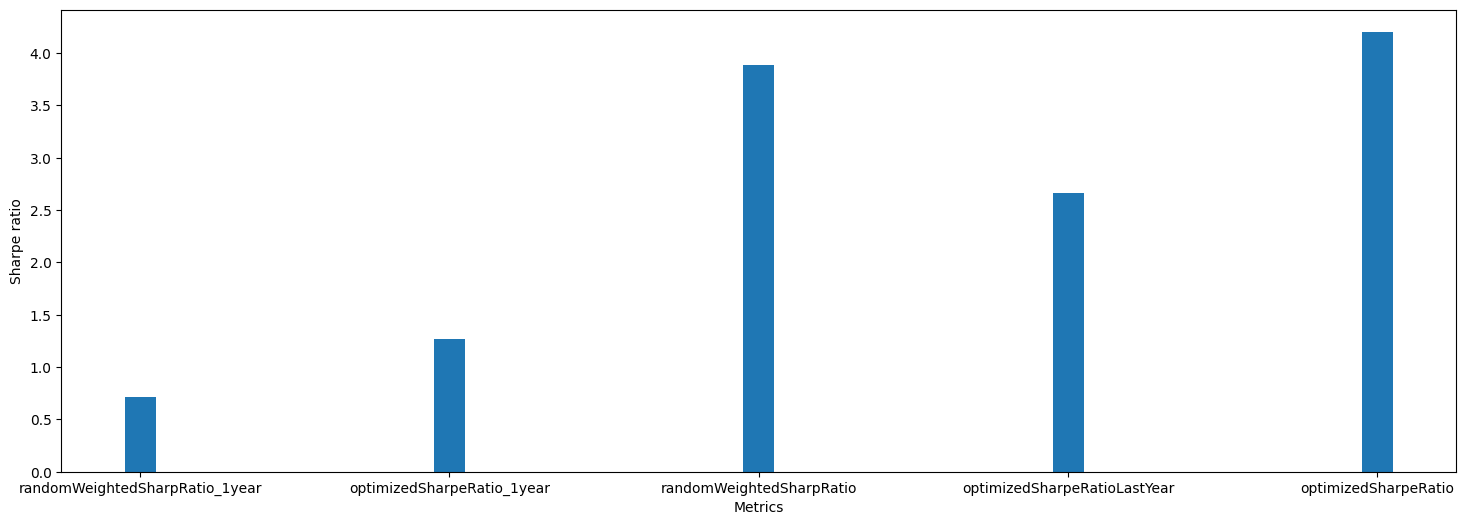

In [27]:

labels = [ 'randomWeightedSharpRatio_1year','optimizedSharpeRatio_1year', 'randomWeightedSharpRatio','optimizedSharpeRatioLastYear', 'optimizedSharpeRatio']
values = [ randomWeightedSharpRatio_1year, optimizedSharpeRatio_1year,randomWeightedSharpRatio, optimizedSharpeRatioLastYear ,optimizedSharpeRatio]

# Plotting the bar chart
plt.figure(figsize=(18, 6))
plt.bar(labels, values, width=0.1)
plt.xlabel('Metrics')
plt.ylabel('Sharpe ratio')
plt.show()

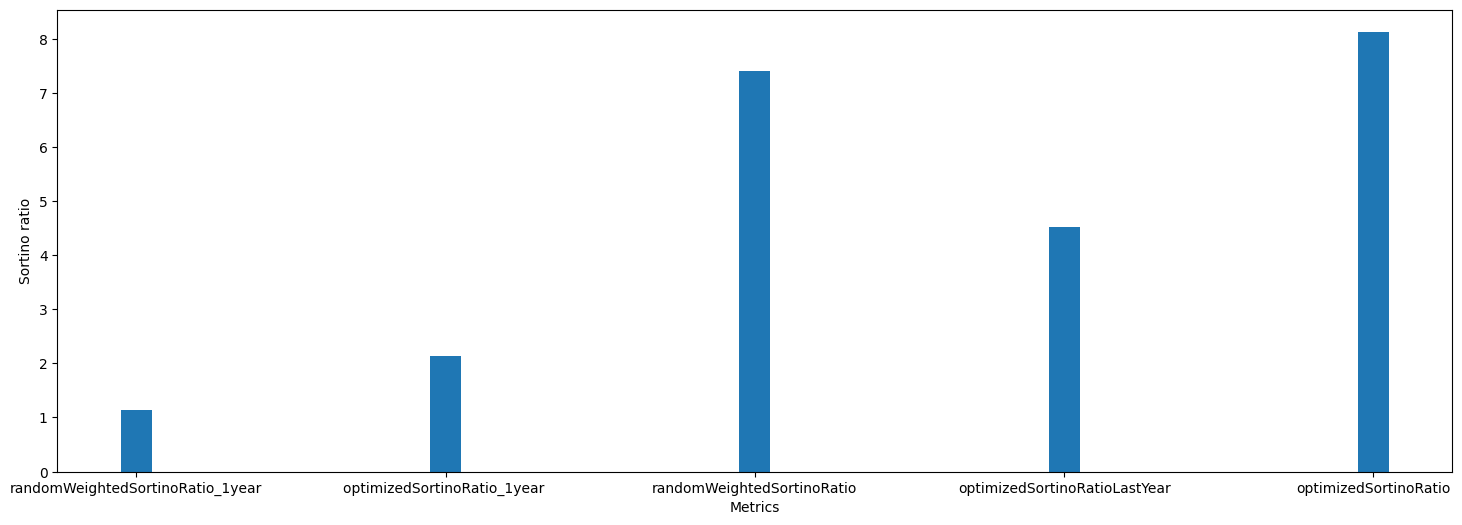

In [28]:

labels = [ 'randomWeightedSortinoRatio_1year','optimizedSortinoRatio_1year ','randomWeightedSortinoRatio','optimizedSortinoRatioLastYear', 'optimizedSortinoRatio']
values = [ randomWeightedSortinoRatio_1year,   optimizedSortinoRatio_1year ,randomWeightedSortinoRatio, optimizedSortinoRatioLastYear ,optimizedSortinoRatio]

# Plotting the bar chart
plt.figure(figsize=(18, 6))
plt.bar(labels, values, width=0.1)
plt.xlabel('Metrics')
plt.ylabel('Sortino ratio')
plt.show()

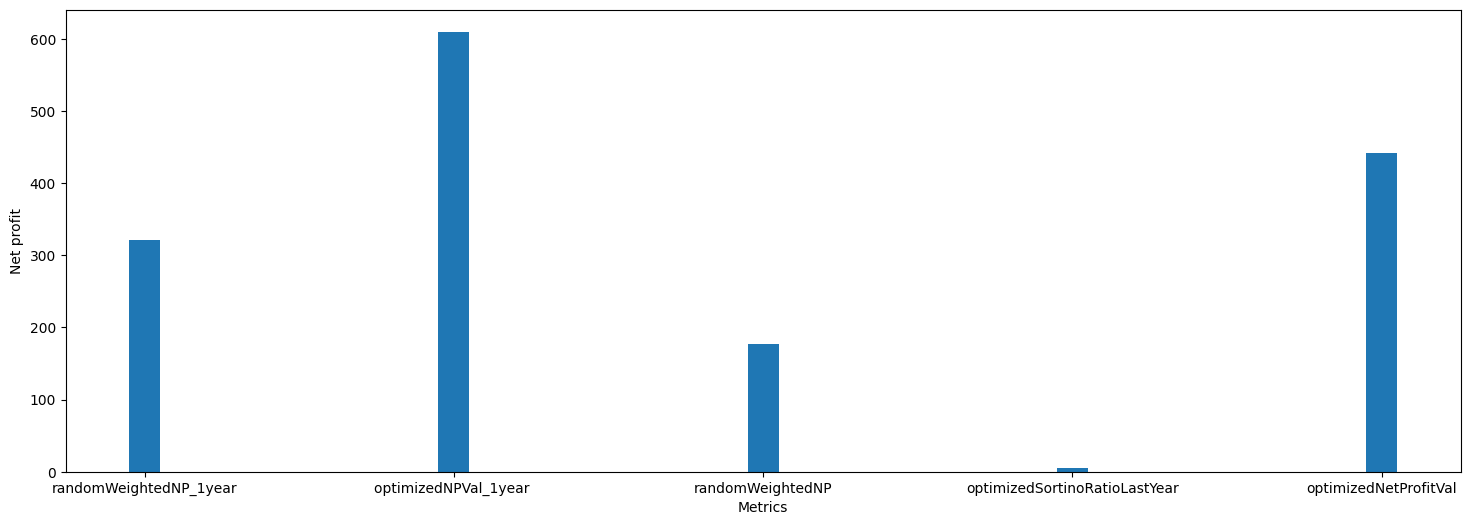

In [29]:
labels = [ 'randomWeightedNP_1year','optimizedNPVal_1year ','randomWeightedNP','optimizedSortinoRatioLastYear', 'optimizedNetProfitVal']
values = [ final_net_profit_year1,   optimizedNetProfitVal_1year ,final_net_profit, optimizedSortinoRatioLastYear ,optimizedNetProfitVal]

# Plotting the bar chart
plt.figure(figsize=(18, 6))
plt.bar(labels, values, width=0.1)
plt.xlabel('Metrics')
plt.ylabel('Net profit')
plt.show()

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

# Using a mix optimized weights of last year
 


In [ ]:
test_start = datetime(2023, 11, 2, tzinfo=timezone('Asia/Tehran'))
test_end = datetime(2023, 12, 2, tzinfo=timezone('Asia/Tehran'))
new_df =  download_data(cryptos, test_start, test_end)

In [ ]:
randomWeights = [0.2, 0.5, 0.2, 0.1]

money_at_first = 1000

ret_data = new_df.pct_change()[1:]

# print(ret_data)

randomweighted_returns = (randomWeights * ret_data)
# print(randomweighted_returns)
port_ret_with_random_weights = randomweighted_returns.sum(axis=1)

# fig = plt.figure()
# ax1 = fig.add_axes([0.1,0.1,0.8,0.8])
# ax1.hist(port_ret, bins = 60)
# ax1.set_xlabel('Portfolio returns')
# ax1.set_ylabel("Freq")
# ax1.set_title("Portfolio Returns calculated manually")
# plt.show(); 
# print(port_ret_with_random_weights)

In [ ]:
expected_port_return = np.mean(port_ret_with_random_weights) 
annual_risk_free_ratio = 0.04
daily_risk_free_ratio =  (1+annual_risk_free_ratio) ** (1/365) -1
std_of_returns = np.std(port_ret_with_random_weights)
initialCapital = 1000
randomWeightedSharpRatio = np.sqrt(365) * ((expected_port_return - daily_risk_free_ratio) / std_of_returns)
randomWeightedSortinoRatio = np.sqrt(365) * sortinoRate(port_ret_with_random_weights , 0)
port_cumulative_returns  = np.cumprod(1+port_ret_with_random_weights)
net_profit_over_time = initialCapital * port_cumulative_returns

final_net_profit = net_profit_over_time[-1] - initialCapital
final_net_profit_percent = final_net_profit/initialCapital * 100
print("Random Weight Sharpe Ratio:{:.3f}".format(randomWeightedSharpRatio))
print("Random Weight Sortino Ratio:{:.2f}".format(randomWeightedSortinoRatio))
print("Random Weight Net Profit: {:.4f}$".format(final_net_profit) + " percentage:" + "{:.2f}%".format(final_net_profit_percent))

### Optimizing sharpe for the 1 month period


In [ ]:
op_expectedPortfolioReturnLastYear  , op_stdDevRet, port_rets , op_port_cumulative_returns = calculateRequirements(weights=mixed_weights_last_year)
optimizedSharpeRatioLastYear = calcSharpe(op_expectedPortfolioReturnLastYear , op_stdDevRet)


optimizedSharpe = minimize(get_reverse_sharpeRatio , initialWeightGuess , method='SLSQP' , bounds=bounds , constraints=constraints)
op_weights_for_sharpe = optimizedSharpe.x
print("OUR RANDOM WEIGHTS: ")
print(randomWeights)
print('-' *100)


print("OPTIMIZED WEIGHTS FOR SHARPE: ")
print(op_weights_for_sharpe)
print('-' *100)


op_expectedPortfolioReturn  , op_stdDevRet, port_rets , op_port_cumulative_returns = calculateRequirements(weights=op_weights_for_sharpe)
optimizedSharpeRatio = calcSharpe(op_expectedPortfolioReturn , op_stdDevRet)


print("SHARPE WITH RANDOM WEIGHTS:")
print(randomWeightedSharpRatio)
print('-' *100)
print("SHARPE WITH OPTIMIZED WEIGHTS ON LAST YEAR:")
print(optimizedSharpeRatioLastYear)
print('-'*100)
print("SHARPE WITH OPTIMIZED WEIGHTS ON LAST MONTH:")
print(optimizedSharpeRatio)

### Optimizing sortino for the 1 month period


In [ ]:
op_expectedPortfolioReturn , op_stdDevRet, port_rets , op_port_cumulative_returns = calculateRequirements(weights=mixed_weights_last_year)
optimizedSortinoRatioLastYear = calcSortino(portRets=port_rets)

optimizedSortino = minimize(get_reverse_sortinoRatio , initialWeightGuess , method='SLSQP' , bounds=bounds , constraints=constraints)

op_weights_for_sortino = optimizedSortino.x

print("OUR RANDOM WEIGHTS: ")
print(randomWeights)
print('-' *100)


print("OPTIMIZED WEIGHTS FOR SORTINO: ")
print(op_weights_for_sortino)
print('-' *100)


op_expectedPortfolioReturn  , op_stdDevRet, port_rets , op_port_cumulative_returns = calculateRequirements(weights=op_weights_for_sortino)
optimizedSortinoRatio = calcSortino(portRets=port_rets)


print("SORTINO WITH RANDOM WEIGHTS:")
print(randomWeightedSortinoRatio)
print('-' *100)
print("SORTINO WITH OPTIMIZED WEIGHTS ON LAST YEAR:")
print(optimizedSortinoRatioLastYear)
print('-' *100)
print("SORTINO WITH OPTIMIZED WEIGHTS ON LAST MONTH:")
print(optimizedSortinoRatio)

### Optimizing net profit for the 1 month period


In [ ]:
(
    op_expectedPortfolioReturn,
    op_stdDevRet,
    port_rets,
    op_port_cumulative_returns,
) = calculateRequirements(weights=mixed_weights_last_year)
optimizedNetProfitValLastYear = calcNetProfit(
    op_port_cumulative_returns=op_port_cumulative_returns
)
optimizedNetProfitPercentLastYear = optimizedNetProfitValLastYear / initialCapital * 100


optimizedNetProfit = minimize(
    get_reverse_net_profit,
    initialWeightGuess,
    method="SLSQP",
    bounds=bounds,
    constraints=constraints,
)

op_weights_for_net_profit = optimizedNetProfit.x
print("OUR RANDOM WEIGHTS: ")
print(randomWeights)
print("-" * 100)


print("OPTIMIZED WEIGHTS FOR NET PROFIT: ")
print(op_weights_for_net_profit)
print("-" * 100)


(
    op_expectedPortfolioReturn,
    op_stdDevRet,
    port_rets,
    op_port_cumulative_returns,
) = calculateRequirements(weights=op_weights_for_net_profit)
optimizedNetProfitVal = calcNetProfit(
    op_port_cumulative_returns=op_port_cumulative_returns
)
optimizedNetProfitPercent = optimizedNetProfitVal / initialCapital * 100

print("NET Profit WITH RANDOM WEIGHTS:")
print("{:.2f}".format(final_net_profit) + '$' + " percentage: " + "{:.2f}%".format(final_net_profit_percent))
print("-" * 100)

print("NET PROFIT WITH OPTIMIZED WEIGHTS ON LAST YEAR:")
print(
    "{:.2f}".format(optimizedNetProfitValLastYear) + '$'+
     ' percentage: '
    + "{:.2f}%".format(optimizedNetProfitPercentLastYear)
)
print("-" * 100)
print("NET PROFIT WITH OPTIMIZED WEIGHTS ON LAST MONTH:")
print(
    "{:.2f}".format(optimizedNetProfitVal) + '$'+
     ' percentage: '
    + "{:.2f}%".format(optimizedNetProfitPercent)
)

### Optimizing metrics for the 1 month period based on mixing optimized weights.


In [ ]:
# mixed_weights = mix_weights(op_weights_for_sharpe, op_weights_for_sortino, op_weights_for_net_profit)

# mixed_return  , op_stdDevRet, port_rets , op_port_cumulative_returns = calculateRequirements(weights=mixed_weights)
# mixed_sharpe = calcSharpe(mixed_return , op_stdDevRet)
# mixed_sortino = calcSortino(portRets=port_rets)
# mixed_net_profit_val= calcNetProfit(
#     op_port_cumulative_returns=op_port_cumulative_returns
# )
# net_profit_percent = mixed_net_profit_val / initialCapital * 100


# print("OPTIMIZED WEIGHTS FOR MIX OF 3 METRICS: ")
# print(mixed_weights)
# print('-' * 100)
# print('SHARPE RATIO:\n', randomWeightedSharpRatio, ' ---->', mixed_sharpe)
# print('-' * 100)
# print('SORTINO RATIO:\n', randomWeightedSortinoRatio, ' ----> ', mixed_sortino)
# print('-' * 100)
# print('NET PROFIT:')
# print(final_net_profit, ' ----> ',
#     "{:.2f}".format(mixed_net_profit_val) + '$'+
#      ' percentage: '
#     + "{:.2f}%".format(net_profit_percent)
# )
# print("-" * 100)


In [ ]:
print('Net Profit:\n')
print('Random       Lastyear       OPTIMIZED')
print(f'{round(final_net_profit,2)}       {round(optimizedNetProfitValLastYear)}            {round(optimizedNetProfitVal,2)}')
random_metrics = [randomWeightedSharpRatio, randomWeightedSortinoRatio,]
last_year_metrics = [optimizedSharpeRatioLastYear, optimizedSortinoRatioLastYear,]
mixed_metrics = [optimizedSharpeRatio, optimizedSortinoRatio, ]

labels = ['Sharpe Ratio', 'Sortino Ratio']

x = range(len(labels))

plt.bar(x, mixed_metrics, width=0.2, label='mixed', color='r', align='center')
plt.bar(x, random_metrics, width=0.2, label='random', color='b', align='center')
plt.bar(x, last_year_metrics, width=0.2, label='last year', color='g', align='edge')

plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Comparison')
plt.xticks(x, labels)
plt.legend()
plt.show()
